# New York City Crash Report 
## Group E (NYC Crashers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import requests
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Reading and Assessment of Data 

In [ ]:
df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', encoding='latin1')
df.info()

In [ ]:
df.describe()

In [ ]:
df.head(10).T

* Assessment of the data's top values

In [5]:
df["CONTRIBUTING FACTOR VEHICLE 1"].value_counts()

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                       705280
Driver Inattention/Distraction    413784
Failure to Yield Right-of-Way     122835
Following Too Closely             110541
Backing Unsafely                   76540
                                   ...  
Windshield Inadequate                 80
Cell Phone (hand-held)                79
Texting                               51
Listening/Using Headphones            24
1                                     10
Name: count, Length: 61, dtype: int64

In [6]:
for i in range(1,6):
    df_cfv = df["CONTRIBUTING FACTOR VEHICLE "+str(i)].value_counts()
    print(f"===================== Contributing factor {i} =============================")
    print(df_cfv)

===================== Contributing factor 1 =============================
CONTRIBUTING FACTOR VEHICLE 1
Unspecified                       705280
Driver Inattention/Distraction    413784
Failure to Yield Right-of-Way     122835
Following Too Closely             110541
Backing Unsafely                   76540
                                   ...  
Windshield Inadequate                 80
Cell Phone (hand-held)                79
Texting                               51
Listening/Using Headphones            24
1                                     10
Name: count, Length: 61, dtype: int64
===================== Contributing factor 2 =============================
CONTRIBUTING FACTOR VEHICLE 2
Unspecified                       1472581
Driver Inattention/Distraction      93998
Other Vehicular                     31985
Following Too Closely               18963
Failure to Yield Right-of-Way       17078
                                   ...   
Eating or Drinking                     11
Listening

In [ ]:
df.isnull().sum()

Seeeing as Columns CONTRIBUTING FACTOR VEHICLE 3-5 and VEHICLE TYPE CODE 3-5 are columns that are mostly empty we can drop these columns and focus on the main data in order to furhter our analysis.

In [8]:
df.drop(['CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5'],axis=1,inplace=True)
df.drop(['VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5'],axis=1,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069364 entries, 0 to 2069363
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [9]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

In [10]:
v_type1 = df['VEHICLE TYPE CODE 1'].value_counts()

In [11]:
v_type2 = df['VEHICLE TYPE CODE 2'].value_counts()

In [ ]:
sns.barplot(v_type1[0:10])
plt.xticks(rotation=90)


In [ ]:
sns.barplot(v_type2[0:10])
plt.xticks(rotation=90)

The API application that is proposed will most likely be built using a K-Means clustering algorithm so in this case the best feature to use would be the longitude and latitude features. However some coordinates are missing so if the street names are provided for those missing rows, the values can be obtained using the OpenStreetMap Nominatim  API.

In [14]:
df_no_locs = df[df['LOCATION'].isna()]
df_street_names = df_no_locs[df_no_locs['ON STREET NAME'].notna()].shape

From the column above there are 177173 columns where the street name is known but not the location so we can input this data into the OpenStreetMap Nominatim API and get the approximate coordinates of the accidents. Since the dataset is soo large the other rows where the data is not known can simply be dropped as it may not have a ssignificant effect on the outcome of the analysis.

In [15]:
'''
addresses = list(df_street_names['ON STREET NAME'])
locations = []
for address in addresses:
    base_url = 'https://nominatim.openstreetmap.org/search'
    params = {'q': address, 'format': 'json'}
    response = requests.get(base_url, params=params)
    data = response.json()

    if data:
        lat = float(data[0]['lat'])
        lon = float(data[0]['lon'])
        locations = [lat,lon]
    else:
        print("Error receiving coordinates")
'''

'\naddresses = list(df_street_names[\'ON STREET NAME\'])\nlocations = []\nfor address in addresses:\n    base_url = \'https://nominatim.openstreetmap.org/search\'\n    params = {\'q\': address, \'format\': \'json\'}\n    response = requests.get(base_url, params=params)\n    data = response.json()\n\n    if data:\n        lat = float(data[0][\'lat\'])\n        lon = float(data[0][\'lon\'])\n        locations = [lat,lon]\n    else:\n        print("Error receiving coordinates")\n'

In [16]:
df['NUM PERSONS AFFECTED'] = df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']

In [85]:
reg_df = df[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','LOCATION','LONGITUDE','LATITUDE']]
reg_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED,LOCATION,LONGITUDE,LATITUDE
0,2021-09-11,2:39,NaN,2.0,0.0,2.0,NaN,NaN,NaN
1,2022-03-26,11:45,NaN,1.0,0.0,1.0,NaN,NaN,NaN
2,2022-06-29,6:55,NaN,0.0,0.0,0.0,NaN,NaN,NaN
3,2021-09-11,9:35,BROOKLYN,0.0,0.0,0.0,"(40.667202, -73.8665)",-73.866500,40.667202
4,2021-12-14,8:13,BROOKLYN,0.0,0.0,0.0,"(40.683304, -73.917274)",-73.917274,40.683304


In [18]:
reg_df['BOROUGH'].unique()

array([nan, 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [ ]:
reg_df['Month'] = reg_df['CRASH DATE'].dt.month
reg_df['Year'] = reg_df['CRASH DATE'].dt.year
reg_df['month_year'] = reg_df['CRASH DATE'].dt.to_period('M')
reg_df['month_year'] = reg_df['month_year'].astype(str)
reg_df['month_year'] = pd.to_datetime(reg_df['month_year'])

In [20]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069364 entries, 0 to 2069363
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   CRASH DATE                 datetime64[ns]
 1   CRASH TIME                 object        
 2   BOROUGH                    object        
 3   NUMBER OF PERSONS INJURED  float64       
 4   NUMBER OF PERSONS KILLED   float64       
 5   NUM PERSONS AFFECTED       float64       
 6   Month                      int32         
 7   Year                       int32         
 8   month_year                 datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int32(2), object(2)
memory usage: 126.3+ MB


In [21]:
reg_df_2 = reg_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']]
reg_df_2 = reg_df_2.groupby('month_year').sum()
reg_df_2.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED
month_year,,,
2012-07-01,4855.0,22.0,4877.0
2012-08-01,4751.0,27.0,4778.0
2012-09-01,4689.0,26.0,4715.0
2012-10-01,4572.0,21.0,4593.0
2012-11-01,3995.0,14.0,4009.0


In [22]:
reg_df_2['num_injured(thousands)'] = reg_df_2['NUMBER OF PERSONS INJURED']/1000
reg_df_2['num_killed(tens)'] = reg_df_2['NUMBER OF PERSONS KILLED']/10
reg_df_2['num_affected(thousands)'] = reg_df_2['NUM PERSONS AFFECTED']/1000
reg_df_2 = reg_df_2.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)
reg_df_2.head()

,num_injured(thousands),num_killed(tens),num_affected(thousands)
month_year,,,
2012-07-01,4.855,2.2,4.877
2012-08-01,4.751,2.7,4.778
2012-09-01,4.689,2.6,4.715
2012-10-01,4.572,2.1,4.593
2012-11-01,3.995,1.4,4.009


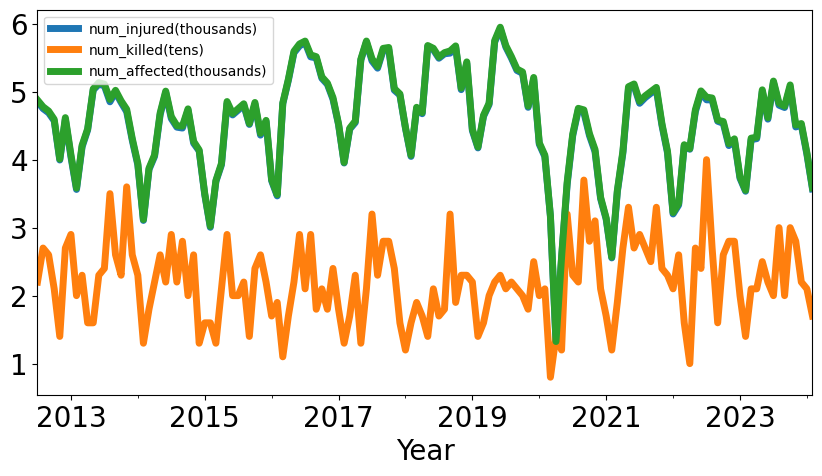

In [61]:
reg_df_2.plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

Text(0.5, 0, 'Year')

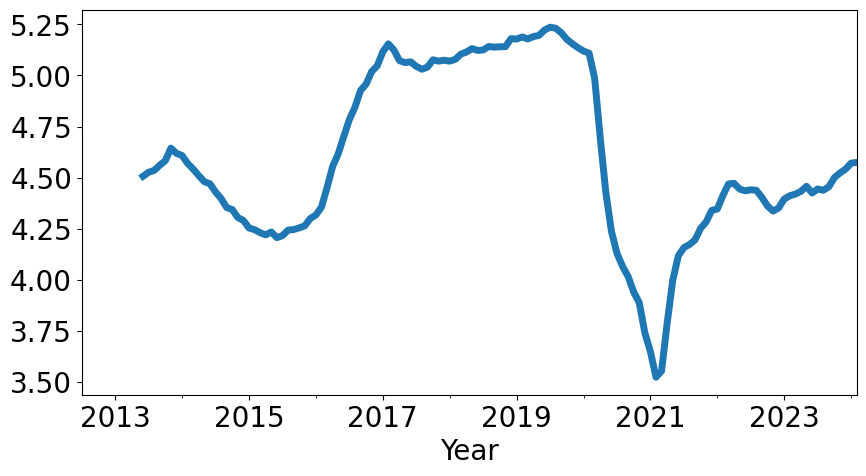

In [24]:
affected = reg_df_2['num_affected(thousands)'].copy()
affected.rolling(12).mean().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

Text(0.5, 0, 'Year')

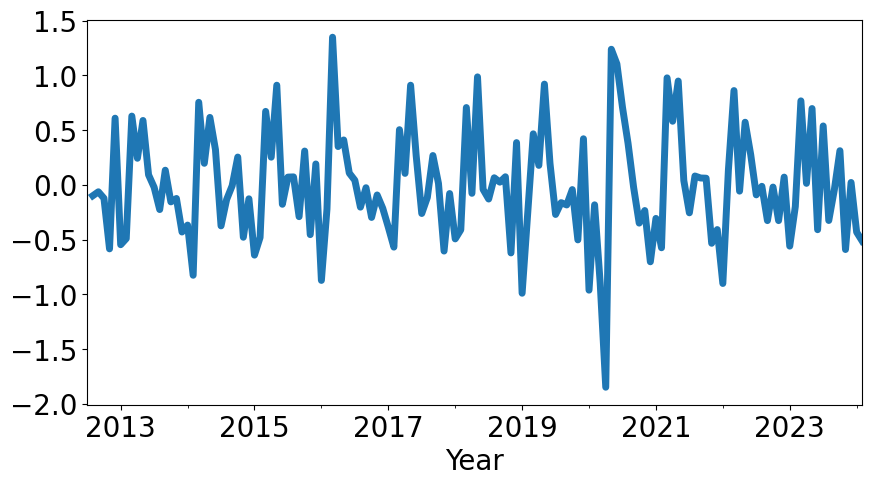

In [25]:
affected.diff().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

In [26]:
affected = reg_df_2[['num_affected(thousands)']].copy()
#affected['num_affected(thousands)'] = reg_df_2['num_affected(thousands)'].astype(np.float64)

In [27]:
affected

,num_affected(thousands)
month_year,
2012-07-01,4.877
2012-08-01,4.778
2012-09-01,4.715
2012-10-01,4.593
2012-11-01,4.009
...,...
2023-10-01,5.099
2023-11-01,4.509
2023-12-01,4.531


In [28]:
train = affected[affected.index.year < 2023]
test = affected[affected.index.year == 2023]

Naive Approach

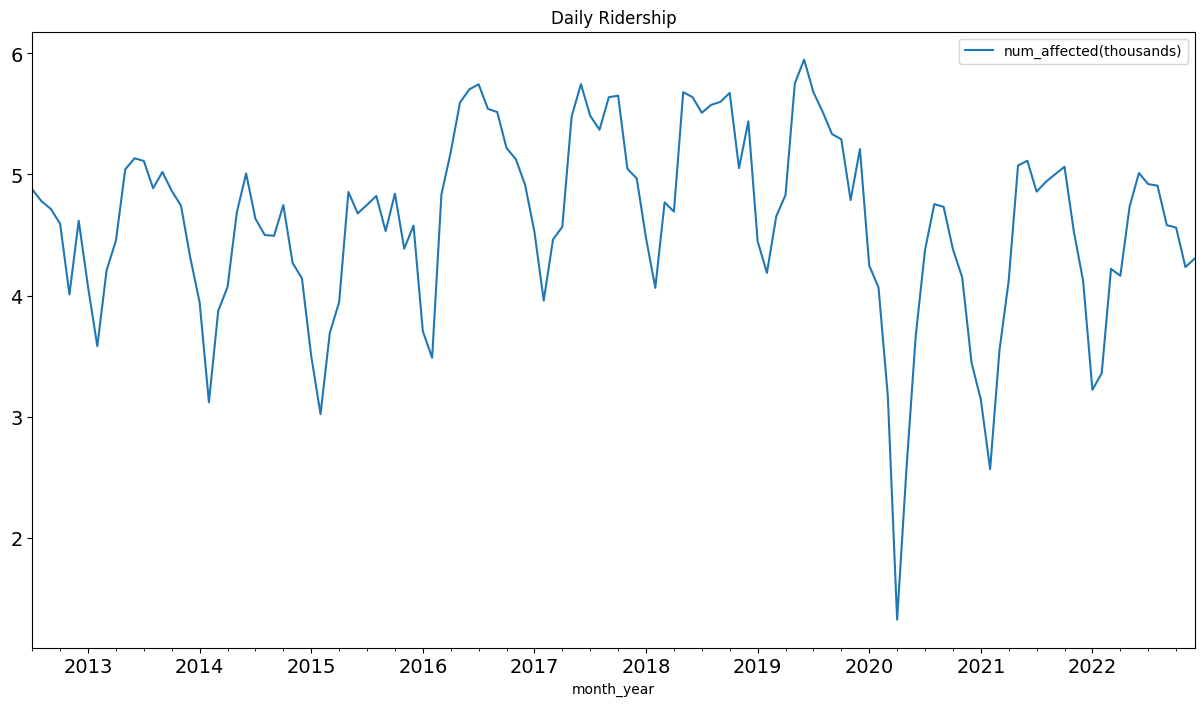

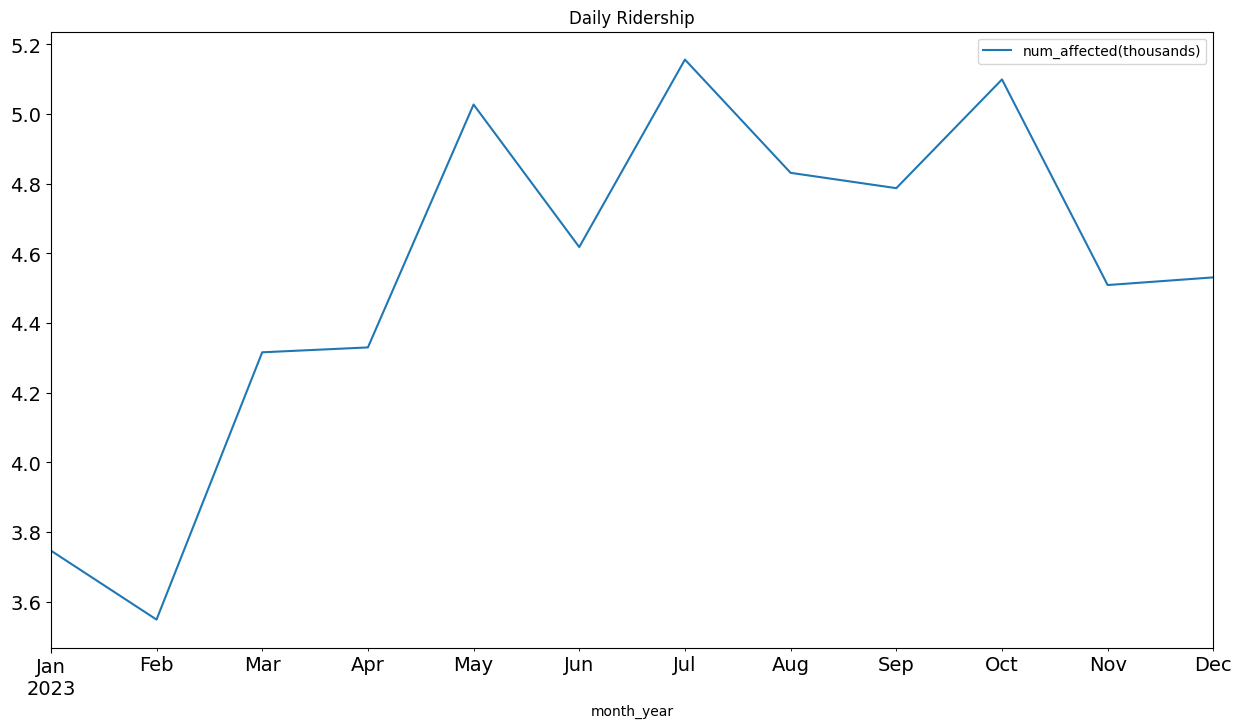

In [29]:
train.plot(figsize=(15,8), title= 'Montly Affected', fontsize=14)
test.plot(figsize=(15,8), title= 'Monthly Affected', fontsize=14)
plt.show()

In [30]:
dd= np.asarray(train['num_affected(thousands)'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

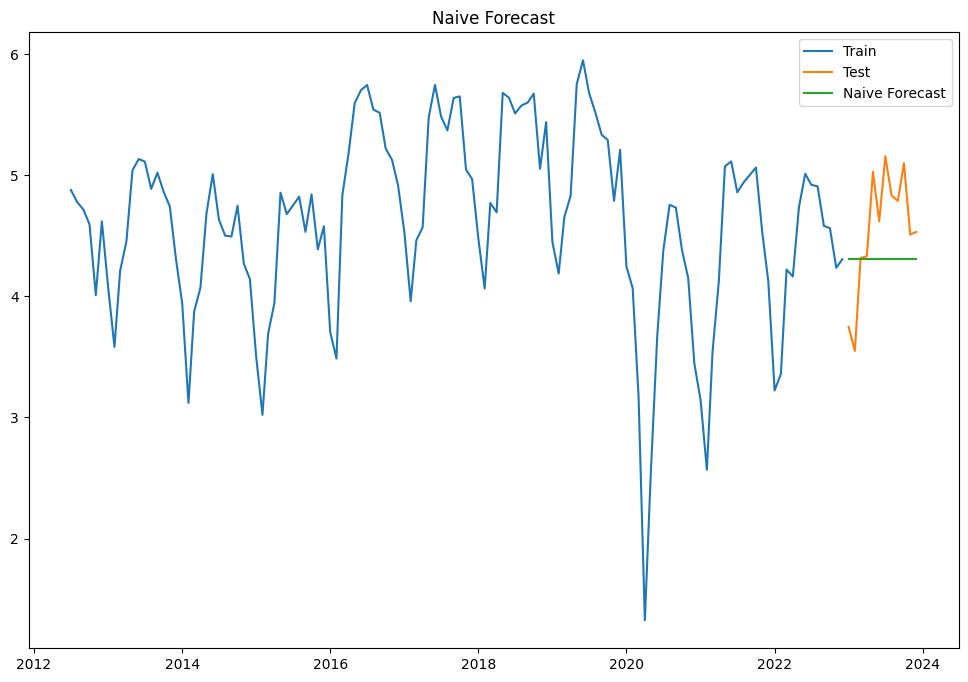

In [31]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index,test, label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [32]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat.naive))
print(rms)

0.5364668365021893


Simple Average

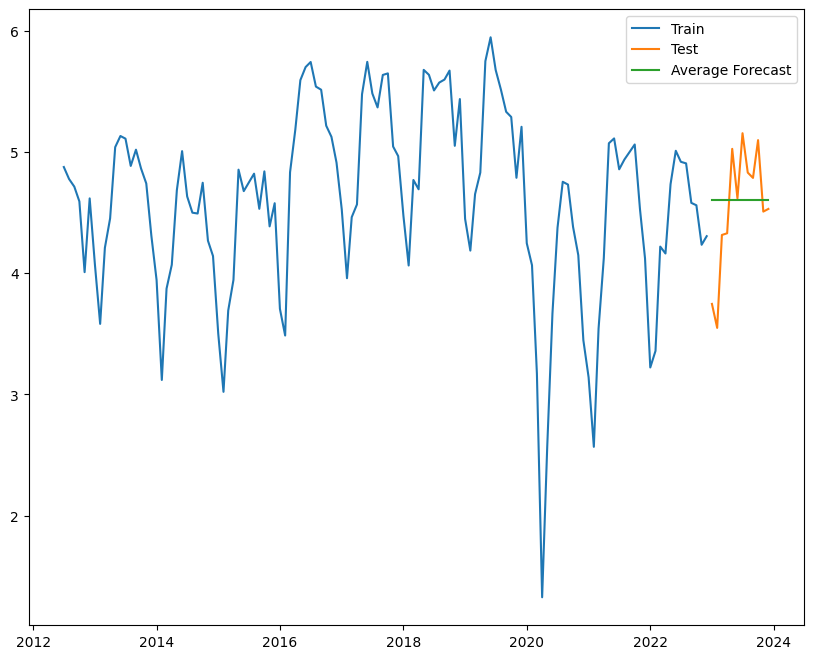

In [33]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['num_affected(thousands)'].mean()
plt.figure(figsize=(10,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [34]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat_avg.avg_forecast))
print(rms)

0.48639427017022097


Moving Average Forecast

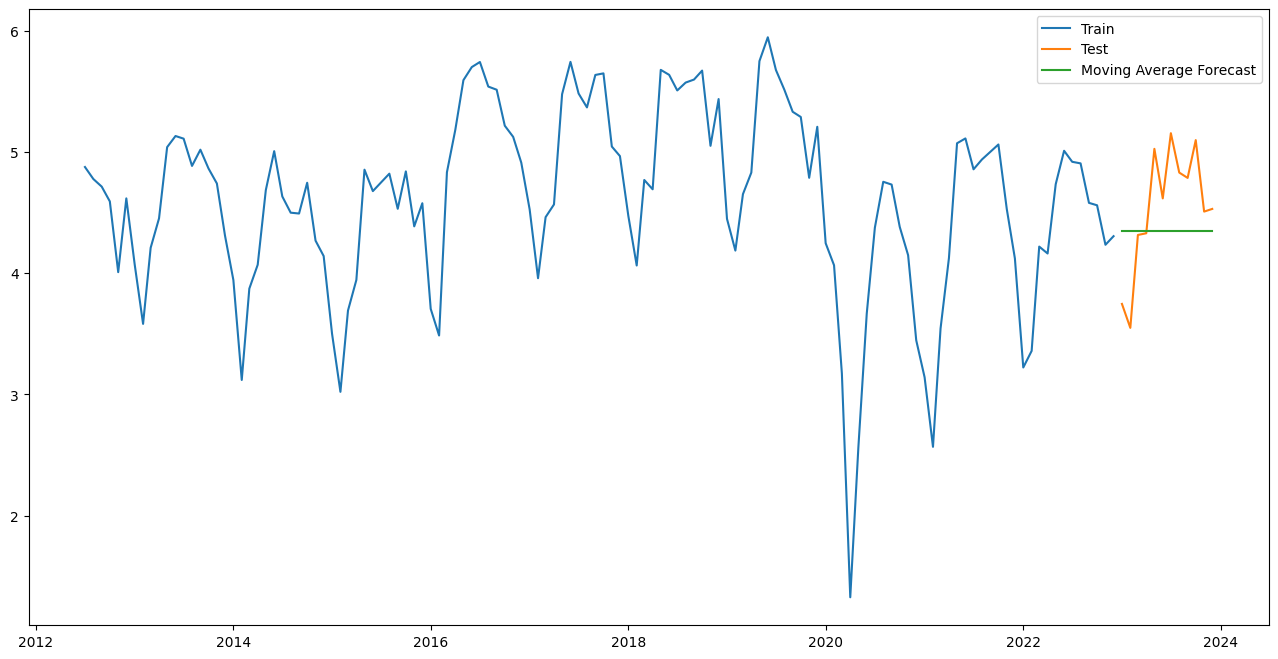

In [35]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['num_affected(thousands)'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [36]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat_avg.moving_avg_forecast))
print(rms)

0.518032710249931


Simple Exponential smoothing

num_affected(thousands)    4.467536
Name: 2022-12-01 00:00:00, dtype: float64 3.747
0.4455905617752793


C:\Users\kiran\AppData\Local\Temp\ipykernel_2984\2795504184.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(ft, test['num_affected(thousands)'][0])
C:\Users\kiran\AppData\Local\Temp\ipykernel_2984\2795504184.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = test['num_affected(thousands)'][i-1]
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
c:\Us

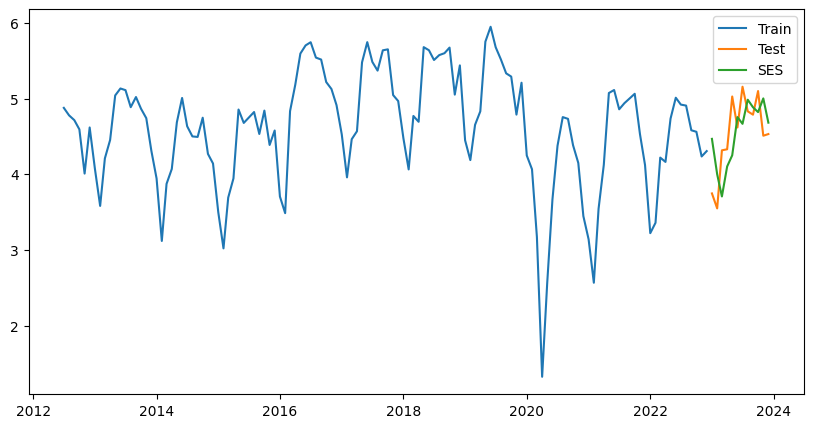

In [37]:
y_hat_avg = test.copy()

pred = []
#s = 9
a = 0.65
#a = 2/(s+1)
#ft = pd.DataFrame.ewm(train, alpha = a).mean()['gym'][-1]
ft = pd.DataFrame.ewm(train, span = 10).mean().iloc[-1]
#ft = train['gym'].mean()
pred.append(ft)
print(ft, test['num_affected(thousands)'][0])
for i in range(1,len(test['num_affected(thousands)'])):
    dt = test['num_affected(thousands)'][i-1]
    ft_plus_1 = a*dt + (1-a)*ft
    #print(i, dt, ft, ft_plus_1)
    pred.append(ft_plus_1)
    ft = ft_plus_1
y_hat_avg['SES'] = pd.Series(pred).values

rms = np.sqrt(mean_squared_error(test, y_hat_avg.SES))
print(rms)

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [38]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat_avg.SES))
print(rms)

0.4455905617752793


c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


ARIMA Model

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

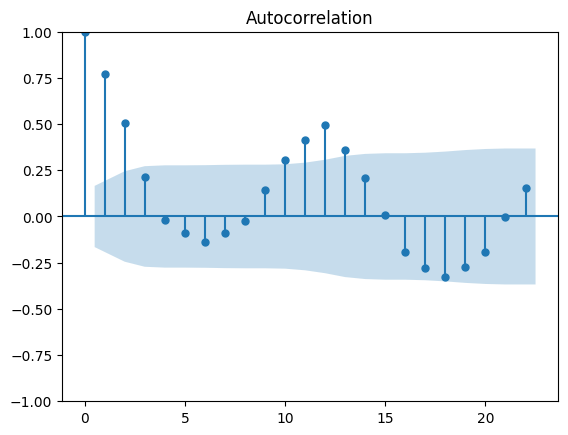

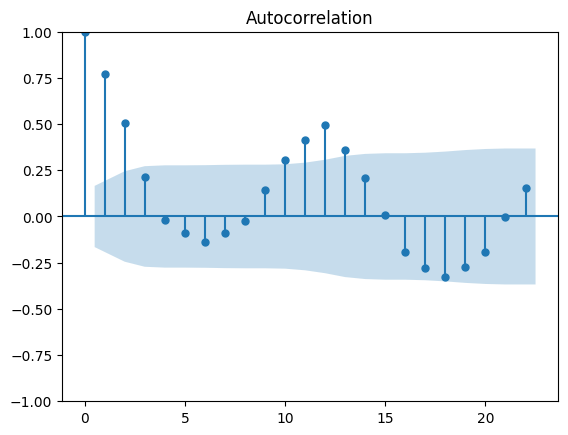

In [40]:
plot_acf(reg_df_2['num_affected(thousands)'])

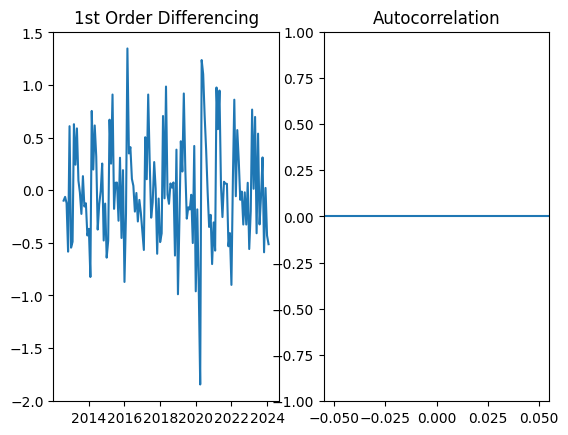

In [41]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(reg_df_2['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(reg_df_2['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

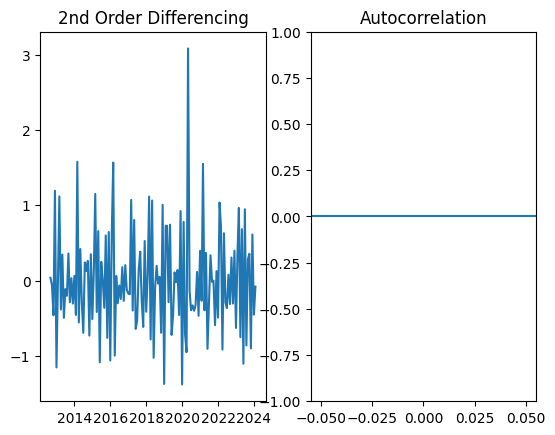

In [42]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(reg_df_2['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(reg_df_2['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [53]:
from statsmodels.tsa.stattools import adfuller

In [55]:
result = adfuller(reg_df_2['num_affected(thousands)'])
print(f"p value: {result[1]}")

#result = adfuller(reg_df_2['num_affected(thousands)'].diff())
#print(f"p value: {result[1]}")

#result = adfuller(reg_df_2['num_affected(thousands)'].diff().diff())
#print(f"p value: {result[1]}")

p value: 0.3123484108136313


It appears that you cant find the difference of this dataset hence we will plot the ARIMA Model based on the original data

In [48]:
from statsmodels.tsa.arima.model import ARIMA

In [49]:
arima_model = ARIMA(reg_df_2['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                 -87.907
Date:                     Sun, 07 Apr 2024   AIC                            185.814
Time:                             16:32:59   BIC                            200.487
Sample:                         07-01-2012   HQIC                           191.777
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5950      0.099      6.025      0.000       0.401       0.789
ma.L1         -0.7589      0.927     -0.818      0.413      -2.577       1.059
ma.L2       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


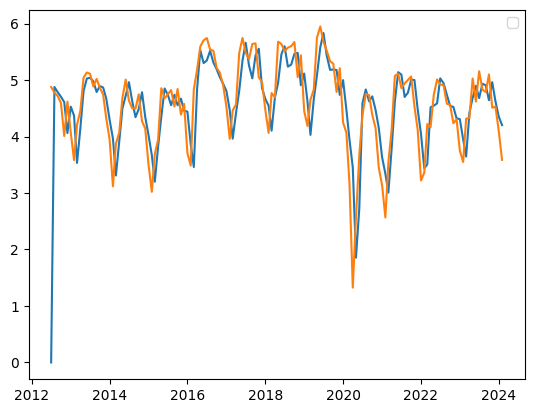

In [50]:
plt.plot(model.predict(dynamic=False))
plt.plot(reg_df_2['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))

(array([19783., 19797., 19814., 19828., 19844., 19858., 19875., 19889.,
        19905.]),
 [Text(19783.0, 0, '2024-03-01'),
  Text(19797.0, 0, '2024-03-15'),
  Text(19814.0, 0, '2024-04-01'),
  Text(19828.0, 0, '2024-04-15'),
  Text(19844.0, 0, '2024-05-01'),
  Text(19858.0, 0, '2024-05-15'),
  Text(19875.0, 0, '2024-06-01'),
  Text(19889.0, 0, '2024-06-15'),
  Text(19905.0, 0, '2024-07-01')])

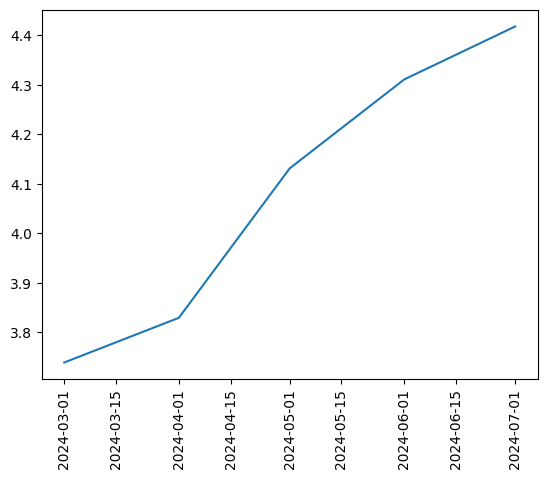

In [51]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)

TIME SERIES BY BOROUGH

In [88]:
reg_df_3 = reg_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year','BOROUGH','LOCATION','LONGITUDE','LATITUDE']]
reg_df_3.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED,month_year,BOROUGH,LOCATION,LONGITUDE,LATITUDE
0,2.0,0.0,2.0,2021-09-01,NaN,NaN,NaN,NaN
1,1.0,0.0,1.0,2022-03-01,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,2022-06-01,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,2021-09-01,BROOKLYN,"(40.667202, -73.8665)",-73.866500,40.667202
4,0.0,0.0,0.0,2021-12-01,BROOKLYN,"(40.683304, -73.917274)",-73.917274,40.683304


In [89]:
print(reg_df_3.isna().sum())
print(reg_df_3.shape)

NUMBER OF PERSONS INJURED        18
NUMBER OF PERSONS KILLED         31
NUM PERSONS AFFECTED             37
month_year                        0
BOROUGH                      643847
LOCATION                     233273
LONGITUDE                    233273
LATITUDE                     233273
dtype: int64
(2069364, 8)


In [101]:
reg_df_3 = reg_df_3.dropna()
reg_df_3.isnull().sum()

NUMBER OF PERSONS INJURED    0
NUMBER OF PERSONS KILLED     0
NUM PERSONS AFFECTED         0
month_year                   0
BOROUGH                      0
LOCATION                     0
LONGITUDE                    0
LATITUDE                     0
dtype: int64

In [102]:
#unusable = reg_df_3[reg_df_3['LOCATION'].isnull() & reg_df_3['BOROUGH'].isnull()].index
#reg_df_3 = reg_df_3.drop(unusable)
#reg_df_3

In [ ]:
reg_df_3_NB = reg_df_3[reg_df_3['BOROUGH'].isnull()]
reg_df_3_NB

In [68]:
from geopy.distance import geodesic

# Define the coordinates for the boundaries of each NYC borough
borough_boundaries = {
    'Manhattan': [(40.698457, -74.019327), (40.872023, -73.910044)],
    'Brooklyn': [(40.570842, -74.042787), (40.739446, -73.833365)],
    'Queens': [(40.477399, -73.866095), (40.806807, -73.700272)],
    'Bronx': [(40.785881, -73.933510), (40.917533, -73.765206)],
    'Staten Island': [(40.477199, -74.259090), (40.651278, -74.034278)]
}

In [94]:
def get_borough_from_coords(latitude, longitude):
    point = (latitude, longitude)
    for borough, boundaries in borough_boundaries.items():
        if boundaries[0][0] <= latitude <= boundaries[1][0] and boundaries[0][1] <= longitude <= boundaries[1][1]:
            return borough
    return 'Unknown'

def add_borough_column(df):
    df['Borough'] = df.apply(lambda row: get_borough_from_coords(row['LATITUDE'], row['LONGITUDE']), axis=1)
    return df

In [ ]:
#reg_df_bor_added = add_borough_column(df[['LONGITUDE','LATITUDE']])
#reg_df_bor_added

In [103]:
df['BOROUGH'].unique()

array([nan, 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [106]:
brook_df = reg_df_3[reg_df_3['BOROUGH'] == 'BROOKLYN']
brook_df = brook_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()

queen_df = reg_df_3[reg_df_3['BOROUGH'] == 'QUEENS']
queen_df = queen_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


bronx_df = reg_df_3[reg_df_3['BOROUGH'] == 'BRONX']
bronx_df = bronx_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


man_df = reg_df_3[reg_df_3['BOROUGH'] == 'MANHATTAN']
man_df = man_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


statIsl_df = reg_df_3[reg_df_3['BOROUGH'] == 'STATEN ISLAND']
statIsl_df = statIsl_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


In [107]:
brook_df['num_injured(thousands)'] = brook_df['NUMBER OF PERSONS INJURED']/1000
brook_df['num_killed(tens)'] = brook_df['NUMBER OF PERSONS KILLED']/10
brook_df['num_affected(thousands)'] = brook_df['NUM PERSONS AFFECTED']/1000
brook_df = brook_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

queen_df['num_injured(thousands)'] = queen_df['NUMBER OF PERSONS INJURED']/1000
queen_df['num_killed(tens)'] = queen_df['NUMBER OF PERSONS KILLED']/10
queen_df['num_affected(thousands)'] = queen_df['NUM PERSONS AFFECTED']/1000
queen_df = queen_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

bronx_df['num_injured(thousands)'] = bronx_df['NUMBER OF PERSONS INJURED']/1000
bronx_df['num_killed(tens)'] = bronx_df['NUMBER OF PERSONS KILLED']/10
bronx_df['num_affected(thousands)'] = bronx_df['NUM PERSONS AFFECTED']/1000
bronx_df = bronx_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

man_df['num_injured(thousands)'] = man_df['NUMBER OF PERSONS INJURED']/1000
man_df['num_killed(tens)'] = man_df['NUMBER OF PERSONS KILLED']/10
man_df['num_affected(thousands)'] = man_df['NUM PERSONS AFFECTED']/1000
man_df = man_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

statIsl_df['num_injured(thousands)'] = statIsl_df['NUMBER OF PERSONS INJURED']/1000
statIsl_df['num_killed(tens)'] = statIsl_df['NUMBER OF PERSONS KILLED']/10
statIsl_df['num_affected(thousands)'] = statIsl_df['NUM PERSONS AFFECTED']/1000
statIsl_df = statIsl_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

Text(0.5, 1.0, 'Affected Persons by Borough')

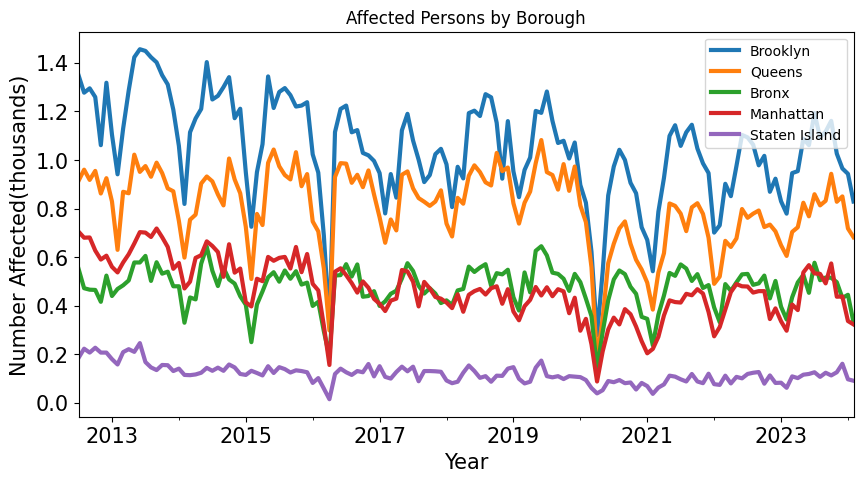

In [114]:
brook_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
queen_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
bronx_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
man_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
statIsl_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.xlabel('Year', fontsize=15);
plt.ylabel('Number Affected(thousands)', fontsize=15);
plt.legend(('Brooklyn','Queens','Bronx','Manhattan','Staten Island'))
plt.title("Affected Persons by Borough")


Text(0.5, 1.0, 'Injured Persons by Borough')

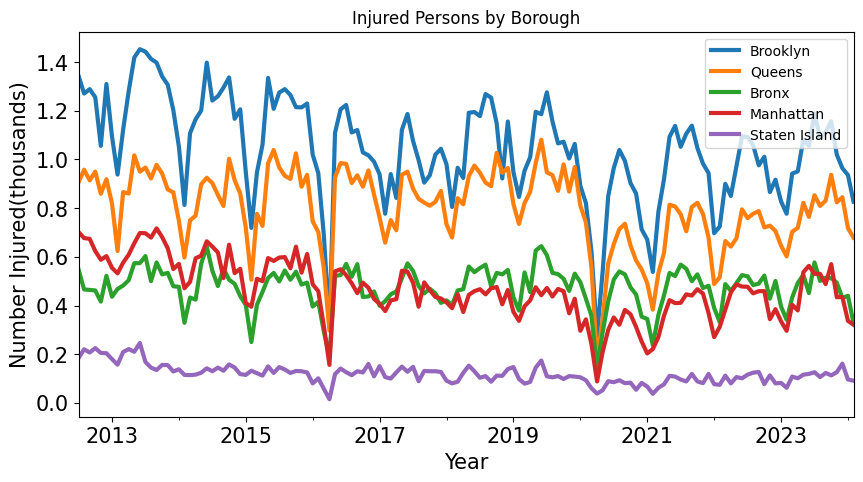

In [116]:
brook_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
queen_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
bronx_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
man_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
statIsl_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.xlabel('Year', fontsize=15);
plt.ylabel('Number Injured(thousands)', fontsize=15);
plt.legend(('Brooklyn','Queens','Bronx','Manhattan','Staten Island'))
plt.title("Injured Persons by Borough")

Text(0.5, 1.0, 'Killed Persons by Borough')

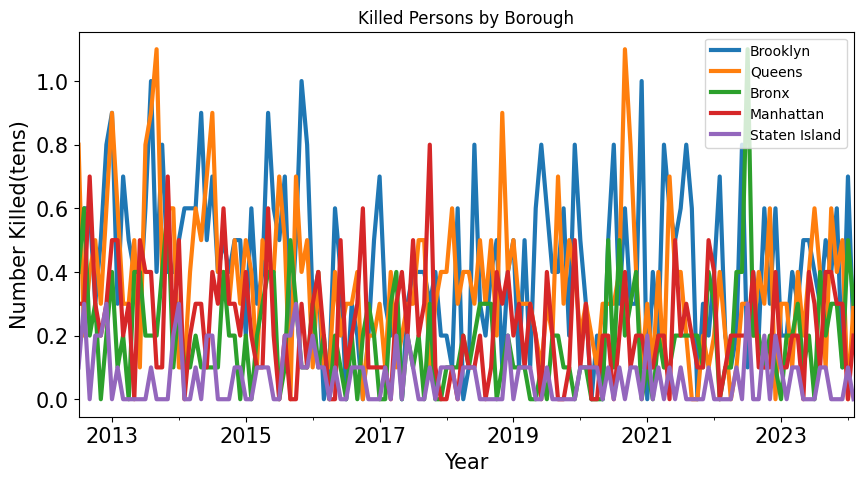

In [117]:
brook_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
queen_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
bronx_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
man_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
statIsl_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.xlabel('Year', fontsize=15);
plt.ylabel('Number Killed(tens)', fontsize=15);
plt.legend(('Brooklyn','Queens','Bronx','Manhattan','Staten Island'))
plt.title("Killed Persons by Borough")

BROOKLYN ARIMA ANALYSIS

In [ ]:
plot_acf(brook_df['num_affected(thousands)'])

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(brook_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(brook_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(brook_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(brook_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [ ]:
result = adfuller(brook_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

In [ ]:
arima_model = ARIMA(brook_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

In [ ]:
plt.plot(model.predict(dynamic=False))
plt.plot(brook_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Brooklyn")

In [ ]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)

<h1>ARIMA Modelling for QUEENS</h1>

In [ ]:
plot_acf(queen_df['num_affected(thousands)'])

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(queen_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(queen_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(queen_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(queen_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [ ]:
result = adfuller(queen_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

In [ ]:
arima_model = ARIMA(queen_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

In [ ]:
plt.plot(model.predict(dynamic=False))
plt.plot(queen_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Queens")

In [ ]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)

<h1>ARIMA Modelling for Bronx</h1>

In [ ]:
plot_acf(bronx_df['num_affected(thousands)'])

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(bronx_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(bronx_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(bronx_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(bronx_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [ ]:
result = adfuller(bronx_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

In [ ]:
arima_model = ARIMA(bronx_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

In [ ]:
plt.plot(model.predict(dynamic=False))
plt.plot(bronx_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in The Bronx")

In [ ]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)

<h1>ARIMA Modelling for Manhattan</h1>

In [ ]:
plot_acf(man_df['num_affected(thousands)'])

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(man_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(man_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(man_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(man_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [ ]:
result = adfuller(man_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

In [ ]:
arima_model = ARIMA(man_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

In [ ]:
plt.plot(model.predict(dynamic=False))
plt.plot(man_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Manhattan")

In [ ]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)

<h1>ARIMA MODELLING FOR STATEN ISLAND</h1>

In [ ]:
plot_acf(statIsl_df['num_affected(thousands)'])

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(statIsl_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(statIsl_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

In [ ]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(statIsl_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(statIsl_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [ ]:
result = adfuller(statIsl_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

In [ ]:
arima_model = ARIMA(statIsl_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

In [ ]:
plt.plot(model.predict(dynamic=False))
plt.plot(statIsl_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Staten Island")

In [ ]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)